In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [4]:
df = pd.read_csv('air-passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


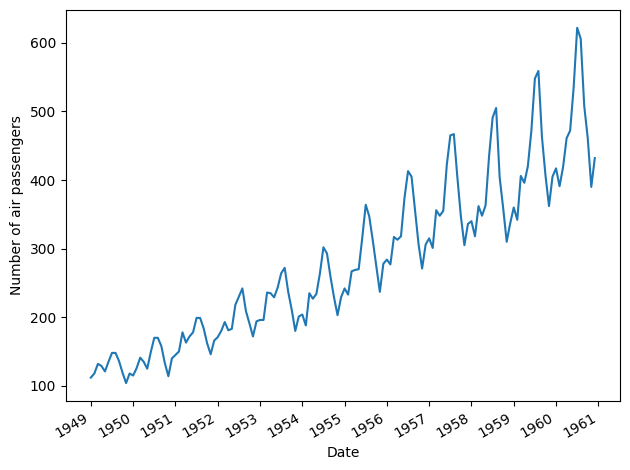

In [5]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'])
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()



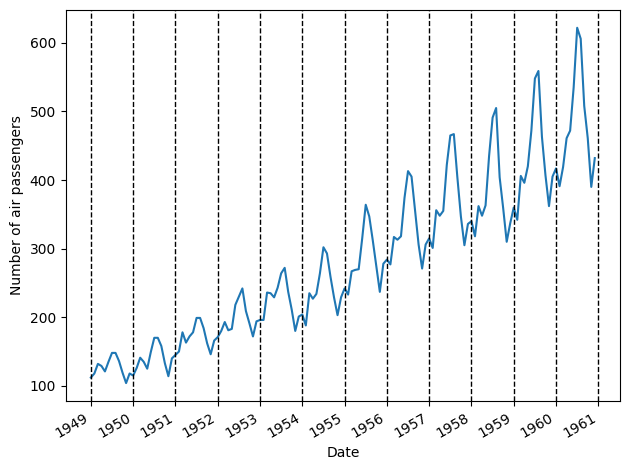

In [6]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'])
for i in np.arange(0, 145, 12):
    ax.axvline(x=i, linestyle='--', color='black', linewidth=1)
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()



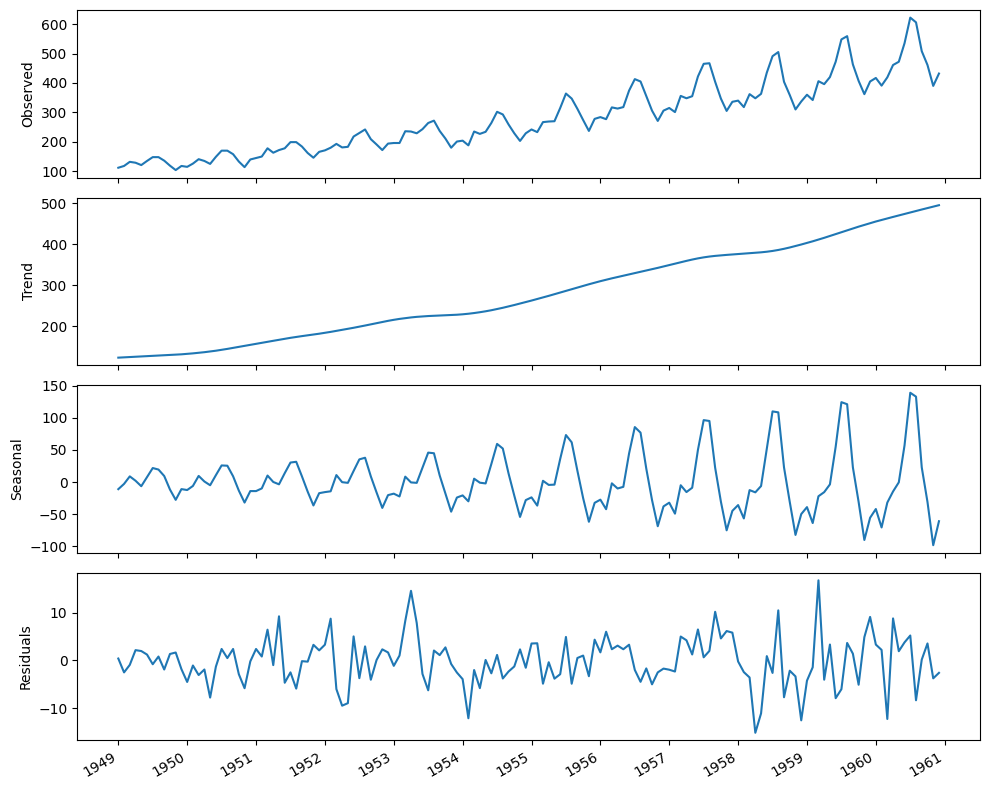

In [7]:
decomposition = STL(df['Passengers'], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()



In [8]:
df_diff = np.diff(df['Passengers'], n=1)

ad_fuller_result = adfuller(df_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.8292668241700074
p-value: 0.05421329028382446


In [9]:
df_diff_seasonal_diff = np.diff(df_diff, n=12)

ad_fuller_result = adfuller(df_diff_seasonal_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -17.624862359924506
p-value: 3.8230468569603574e-30


In [10]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [11]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)
SARIMA_order_list = list(product(ps, qs, Ps, Qs))
train = df['Passengers'][:-12]
d = 1
D = 1
s = 12
SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 1, 1, 2)",892.251096
1,"(2, 1, 2, 1)",894.093313
2,"(2, 1, 1, 3)",894.102411
3,"(1, 0, 1, 2)",894.284455
4,"(0, 1, 1, 2)",894.989155
...,...,...
251,"(0, 0, 2, 0)",906.940147
252,"(3, 2, 0, 3)",907.181875
253,"(0, 0, 3, 2)",907.455898
254,"(0, 0, 3, 0)",908.742583


In [12]:
SARIMA_model = SARIMAX(train, order=(2,1,1), seasonal_order=(1,1,2,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                              Passengers   No. Observations:                  132
Model:             SARIMAX(2, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood                -439.126
Date:                                 Fri, 02 May 2025   AIC                            892.251
Time:                                         19:24:27   BIC                            911.705
Sample:                                              0   HQIC                           900.151
                                                 - 132                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2667      0.085    -14.971      0.000      -1.433      -1

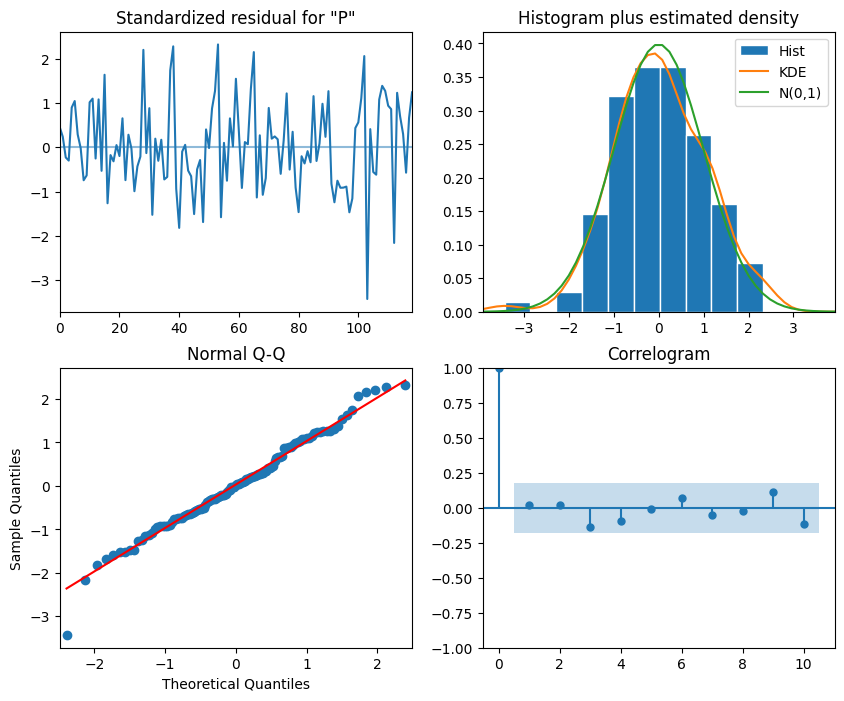

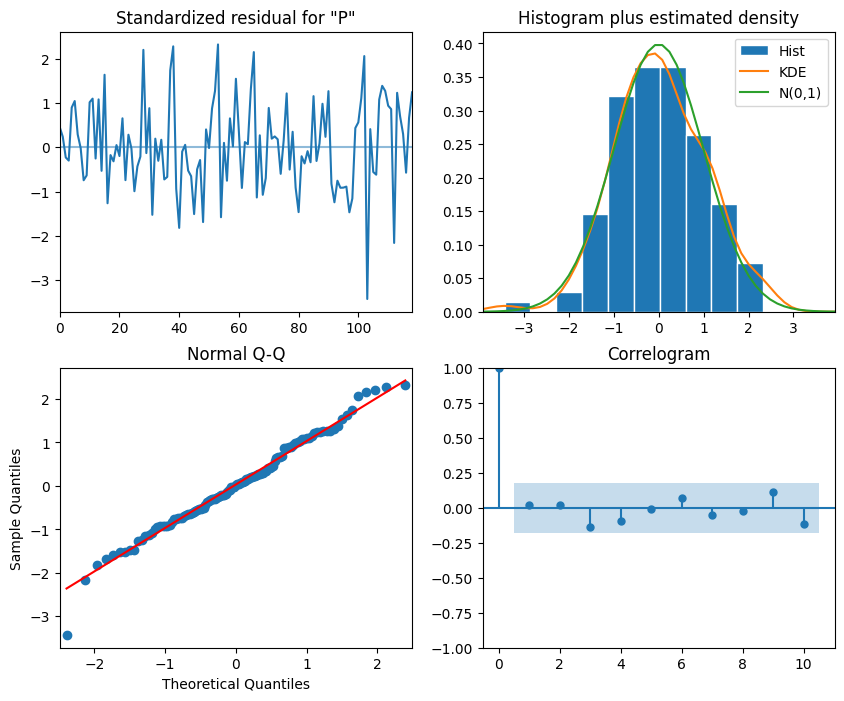

In [15]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))


In [16]:
test = df.iloc[-12:]
SARIMA_pred = SARIMA_model_fit.get_prediction(132, 143).predicted_mean

test['SARIMA_pred'] = SARIMA_pred
test

,Month,Passengers,SARIMA_pred
132,1960-01,417,418.520526
133,1960-02,391,399.578675
134,1960-03,419,461.315065
135,1960-04,461,451.437128
136,1960-05,472,473.749766
137,1960-06,535,538.785571
138,1960-07,622,612.475271
139,1960-08,606,624.663070
140,1960-09,508,520.182728
141,1960-10,461,462.852594


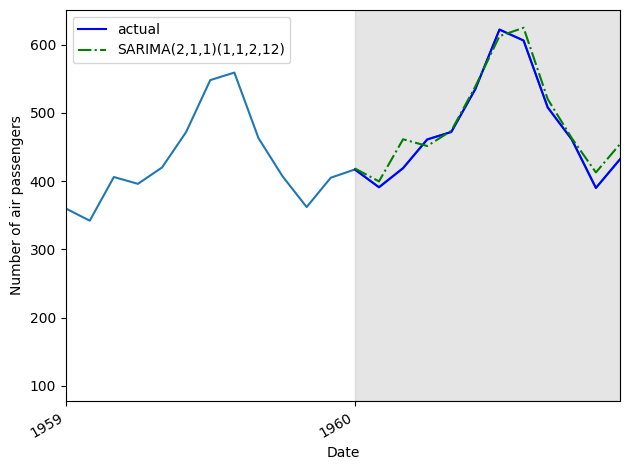

In [17]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'])
ax.plot(test['Passengers'], 'b-', label='actual')
ax.plot(test['SARIMA_pred'], 'g-.', label='SARIMA(2,1,1)(1,1,2,12)')

ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')
ax.axvspan(132, 143, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))
ax.set_xlim(120, 143)

fig.autofmt_xdate()
plt.tight_layout()



In [18]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape_SARIMA = mape(test['Passengers'], test['SARIMA_pred'])
print(f"the MAE of the SARIMA model is {mape_SARIMA.round(2)}%")

the MAE of the SARIMA model is 2.85%
